## Labels
Labels are composed of 3 parts:
* class (there are 13 possible classes) - 13 values
* bounding box predicted by the (i,j) cell - 4 values (c1,c2), w, h

In [572]:
import os
import pandas as pd
import random as rand
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image

#TODO Convert labels from the original format of the dataset to (x1,x2,y1,y2,class). We are interested in annotation['item1']['bounding_box'] and annotation['item1']['category_id']. Note there can be more than one item per image
#TODO Convert labels from (x1,x2,y1,y2,class) to (c1,c2,height,width,confidence,class) 
#        (confidence is the IoU between the bounding box of the prediction and the bounding box of the ground truth, in the labels it must be set to one)
class DataLoader:
    annotations = {}
    images = []
    random_shuffling_for_file_indexes = []
    
    
    def __init__(self, number_of_samples, images_folder, annotations_folder, grid_shape = (3,3), normalize=True, randomize=True, rescale_shape = (256, 256)):
        self.number_of_samples = number_of_samples
        self.images_folder = images_folder
        self.annotations_folder = annotations_folder
        self.grid_shape = grid_shape
        self.rescale_shape = rescale_shape
        self.randomize = randomize
        if self.randomize:
            self._random_shuffling()
        self.images = self.load_n_images()
        self.annotations = self.load_n_annotations()
        self.cleanup_annotations()
        self.rescale()
        self.convert_annotations_onehot_and_xy_to_center_height_width()
        if normalize:
            self.normalize_image()
    
    #use the same shuffling for both images and annotations
    def _random_shuffling(self):
        self.random_shuffling_for_file_indexes = [i for i in range(0, len(self.get_file_names_in_directory(self.images_folder)))]
        rand.shuffle(self.random_shuffling_for_file_indexes)

    def get_file_names_in_directory(self,directory_path):
        res = []
        for path in os.listdir(directory_path):
            # check if current path is a file
            if os.path.isfile(os.path.join(directory_path, path)):
                res.append(path)
        return res

    def load_n_annotations(self):
        annotation = []
        counter = 0
        file_names = self.get_file_names_in_directory(self.annotations_folder)
        for i in range(0, self.number_of_samples):
            clear_output(wait=True)
            annotation.append(pd.read_json(os.path.join(self.annotations_folder, file_names[self.random_shuffling_for_file_indexes[i]] if self.randomize else file_names[i])))
            counter = counter + 1
            print(str(counter / self.number_of_samples * 100.0) + " %")
        return annotation
    
    #Removes unnecessary data
    def cleanup_annotations(self):
        for annotation in self.annotations:
            annotation.drop(labels=["source", "pair_id"], axis="columns", inplace=True)
            annotation.drop(labels=["segmentation", "scale", "viewpoint", "zoom_in", "landmarks", "style", "occlusion"], axis="index", inplace=True)
    
    #Reformats the data in ((c1,c2),w,h,confidence,class) where class is a one-hot vector of the 13 classes
    def convert_annotations_onehot_and_xy_to_center_height_width(self):
        #there are 13 classes
        classes = [i for i in range(1, 14)]

        for i, annotation in enumerate(self.annotations):
            newItems = []
            for (itemID, itemData) in annotation.items():
                boundingbox = itemData["bounding_box"]
                center_1 = boundingbox[0]+(boundingbox[2]/2)
                center_2 = boundingbox[1]+(boundingbox[3]/2)
                height = boundingbox[2]
                width = boundingbox[3]
                confidence = 1
                
                newItem = [center_1, center_2, height, width, confidence] + [self.category_id_to_one_hot(itemData["category_id"])]
                newItems.append(newItem)

            self.annotations[i] = pd.DataFrame(data=newItems, columns=["center_1", "center_2", "height", "width", "confidence", "class_one_hot"]).T
            
    def category_id_to_one_hot(self, category_id):
        one_hot_category_id = []
        number_of_classes = 13
        for i in range(1, number_of_classes+1):
            one_hot_category_id.append(1 if category_id == i else 0)
        return one_hot_category_id
    
    def load_n_images(self):
        images = []
        counter = 0
        images_names = self.get_file_names_in_directory(self.images_folder)
        for i in range(0, self.number_of_samples):
            clear_output(wait=True)
            images.append(mpimg.imread(os.path.join(self.images_folder, images_names[self.random_shuffling_for_file_indexes[i]] if self.randomize else images_names[i])))
            counter = counter + 1
            print(str(counter / self.number_of_samples * 100.0) + " %")
        return images
    
    def rescale(self):
        print("Rescaling")
        for i in range(len(self.images)):
            print(str(i) + ") ")
            im_old_shape = self.rescale_image(self.rescale_shape, i)
            self.rescale_annotation(self.rescale_shape, im_old_shape, i)
            clear_output(wait=True)
        
    def rescale_image(self, im_new_size, idx):
        print("Rescaling an image")
        img_temp = self.images[idx].copy()
        im = Image.fromarray(img_temp)
        img_old_shape = im.size
        im = im.resize(im_new_size)
        self.images[idx] = np.array(im)
        #delete the copied image
        del img_temp
        return img_old_shape
        
    def rescale_annotation(self, im_new_size, im_old_size, idx):
        #for every annotation, adjust the position of the points, based on the rescale of the data
        x_coefficient = im_new_size[0] / im_old_size[0]
        y_coefficient = im_new_size[1] / im_old_size[1]
        print("Rescaling an annotation")
        for (itemID, itemData) in self.annotations[idx].items():
            #print("................. .item id...............................: " + itemID)
            #print(self.annotations[0])
            itemData["bounding_box"][0] = itemData["bounding_box"][0] * x_coefficient
            itemData["bounding_box"][1] = itemData["bounding_box"][1] * y_coefficient
            itemData["bounding_box"][2] = itemData["bounding_box"][2] * x_coefficient
            itemData["bounding_box"][3] = itemData["bounding_box"][3] * y_coefficient
        
    def normalize_image(self):
        for i in range(0, len(self.images)):
            self.images[i] = self.images[i] / 255

In [573]:
images_train_folder_path = "D:/Deep_learning_laboratory/object detection/assignment_1/train/images/"
annotations_train_folder_path = "D:/Deep_learning_laboratory/object detection/assignment_1/train/annotations/"
images_test_folder_path = "D:/Deep_learning_laboratory/object detection/assignment_1/test/images/"
annotations_test_folder_path = "D:/Deep_learning_laboratory/object detection/assignment_1/test/annotations/"

In [574]:
def get_file_names_in_directory(directory_path):
        res = []
        for path in os.listdir(directory_path):
            # check if current path is a file
            if os.path.isfile(os.path.join(directory_path, path)):
                res.append(path)
        return res

In [575]:
dataset_10_examples = DataLoader(number_of_samples = 10,
               images_folder = images_train_folder_path,
               annotations_folder = annotations_train_folder_path)

9) 
Rescaling an image
Rescaling an annotation


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(im)

# Create a Rectangle patch
#rect1 = patches.Rectangle((bounding_box_sample_1[0], bounding_box_sample_1[1]), bounding_box_sample_1[2], bounding_box_sample_1[3], linewidth=1, edgecolor='r', facecolor='none')
rect1 = patches.Rectangle((annotation["item1"]["bounding_box"][0], annotation["item1"]["bounding_box"][1]), annotation["item1"]["bounding_box"][2], annotation["item1"]["bounding_box"][3], linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect1)

plt.show()

In [534]:
assert len(dataset_10_examples.images) == 10
assert len(dataset_10_examples.annotations) == 10

In [198]:
# DEPRECATED CODE, WAS USED AT THE BEGINNING TO CHECK HOW MANY LABELS THERE WAS IN THE DATASET
def show_labels_sorted(dataset):
    category_ids_already_found = []
    for i in range(0, len(dataset.annotations)):
        actualCategoryId = dataset.annotations[i][0]["category_id"]
        if(not(actualCategoryId in category_ids_already_found)):
            category_ids_already_found.append(actualCategoryId)
    category_ids_already_found.sort()
    return category_ids_already_found
def count_labels(dataset):
    return len(show_labels_sorted(dataset))

In [210]:


#Turns the labels into grids of labels where only the grid cells containing the label center have confidence 1
#TODO fix or just work around, doesn't work. It's probably best to just "generate" the grid at runtime rather than writing it as redundant and bloated data in the dataframe
def gridify_annotations_onehot(dataset):

    CELL_GRID_SIDE = 4
    INPUT_IMAGE_SIDE = 256

    cell_size = INPUT_IMAGE_SIDE / CELL_GRID_SIDE
    classes = count_labels(dataset_1000_examples)

    for i, annotation in enumerate(dataset.annotations):
        newItems = []
        columns = []
        for x in range(CELL_GRID_SIDE):
            for y in range(CELL_GRID_SIDE):
                newItem = [(0,0), (0,0), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                for (itemID, itemData) in annotation.items():
                    center = itemData["center"]
                    minX = x * cell_size
                    minY = y * cell_size
                    if (center[0] >= minX & center[0] < minX + cell_size & center[1] >= minY & center[1] < minY + cell_size):
                        newItem = itemData
                newItems.append(newItem)
                columns.append((x,y))
        dataset.annotations[i] = pd.DataFrame(data=newItems, index=columns, columns=["center", "size", "confidence"] + classes).T


In [546]:
#Plot an annotation
#convert_annotations(dataset_1000_examples)
#convert_annotations_onehot(dataset_10_examples)
#gridify_annotations_onehot(dataset_1000_examples)
example = dataset_10_examples.annotations[0]

In [547]:
dataset_10_examples.images[0].shape

(256, 256, 3)

### Check the number of Labels - 13 labels

In [548]:
#test "count the number of categories. There should be 13"
assert len(count_labels(dataset_1000_examples)) == 13

KeyError: 0

### Draw a box from a training sample to see what the json label represents

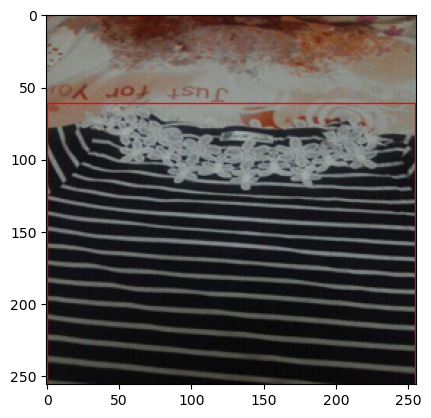

In [576]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

#bounding_box_sample_1 = dataset_1000_examples.annotations[0]["item1"]["bounding_box"]
bounding_box_size = 256
bounding_box_center1 = dataset_10_examples.annotations[2][0]["center_1"]
bounding_box_center2 = dataset_10_examples.annotations[2][0]["center_2"]
bounding_box_height = dataset_10_examples.annotations[2][0]["height"]
bounding_box_width = dataset_10_examples.annotations[2][0]["width"]
# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(dataset_10_examples.images[2])

# Create a Rectangle patch
#rect1 = patches.Rectangle((bounding_box_sample_1[0], bounding_box_sample_1[1]), bounding_box_sample_1[2], bounding_box_sample_1[3], linewidth=1, edgecolor='r', facecolor='none')
rect1 = patches.Rectangle((bounding_box_center1 - bounding_box_height/2, bounding_box_center2 - bounding_box_width/2), bounding_box_height, bounding_box_width, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect1)

plt.show()

## Data we are going to use
We are going to use category and bounding box data, out objective is object detection, hence we will ignore data about segmentation, localization, etc.

## Preprocess
We are going to squash the data into a [0,1] range with normalization for the dataset (faster learning). Before normalization we will apply some data augmentation.
(move this above, we did normalization in the DataLoader class)

In [ ]:
#4) load resnet pretrained model

In [12]:
#5) build the architecture

import torch.nn as nn
import torch.nn.functional as F
import torch as t

#Size of input images
input_size = 256 * 256 #SHOULD BE THE PRODUCT OF output_size AND ANY POWER OF 2 (at least 2^2)
input_channels = 3 #RGB
#Amount of output channels
output_size = 4 * 4 #4x4 grid of cells
output_channels = 6 #(c1,c2,w,h,confidence,class)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        # Bottleneck convolutional layer (repeated with relu and maxpool until desired cell grid size is reached)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=4)
        # Final linear layer 1
        self.fc1 = nn.Linear(in_features = output_size * 16, out_features = output_size * 16)
        # Final linear layer 2
        self.fc2 = nn.Linear(in_features = output_size * 16, out_features = output_size * output_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        for i in range(np.log2((input_size/4)/output_size)):   #Repeat until desired size of cell grid is reached
            x = self.conv3(x)
            x = F.relu(x)
            x = self.pool(x)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

    def custom_loss(output, target):

        CONFIDENCE_WEIGHT, BB_WEIGHT, CLASS_WEIGHT = 1, 1, 1

        output_grid_side = np.sqrt(output_size)
        folded_output = output.view(output_grid_side, output_grid_side, output_channels)
        folded_target = target.view(output_grid_side, output_grid_side, output_channels)

        #Cross entropy of confidences
        confidence_loss = F.binary_cross_entropy_with_logits(input=t.select(folded_output, 2, 4), target=t.select(folded_target, 2, 4))

        #Mean squared error of bounding boxes
        bounding_box_loss = F.mse_loss(input=t.narrow(folded_output, 2, 0, 4), target=t.narrow(folded_target, 2, 0, 4))

        #Cross entropy of one-hot vector of classes
        class_loss = F.binary_cross_entropy_with_logits(input=t.narrow(folded_output, 2, 4, 13), target=t.narrow(folded_target, 2, 4, 13))

        #Add and return all three losses together, weighted
        return t.add(t.mul(confidence_loss, CONFIDENCE_WEIGHT), t.mul(bounding_box_loss, BB_WEIGHT), t.mul(class_loss, CLASS_WEIGHT))



        

net = Net()



D:\Programmi\Anaconda\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#6) implement metrics, training cycle, backprop

In [ ]:
#7) evaluate model on test set

In [ ]:
#8) show some results